# <center>ディープラーニング入門</center>
# <center>セマンティック・セグメンテーションとUNet 2：学習</center>



In [1]:
# tfがエラーはかないため
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# !wget -P './lung_cancer' http://imgcom.jsrt.or.jp/imgcom/wp-content/uploads/2018/12/Segmentation01_RGB.zip

In [4]:
!pwd

/home/input/100knocks


In [5]:
!ls ./lung_cancer

Segmentation01_RGB	Segmentation01_RGB.zip.1  Segmentation01_RGB.zip.3
Segmentation01_RGB.zip	Segmentation01_RGB.zip.2  Segmentation01_RGB.zip.4


In [6]:
# !unzip ./lung_cancer/Segmentation01_RGB.zip

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

今回使うモデルのサイズと深さを決めておきましょう：

In [8]:
SIZE = 128
DEPTH = 4

## 1. UNetの作成

前回のノートブックのコードを少しシンプルにして、DropOutを入れたモデルを作ることにします

In [9]:
from tensorflow.keras import layers
from tensorflow.keras import Model

def conv_block(inputs, kernel_size=(3,3), n_channels=32):
    
    # Convを二回行う
    x = layers.Conv2D(n_channels, kernel_size, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(n_channels, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    return x

def upconv_block(inputs, n_channels=32):
    
    # Upsamplingでサイズを倍にした後、2x2 Convでチャネル数を変更。TransposeConvを使うのでも良い
    x = layers.UpSampling2D((2, 2))(inputs)
    x = layers.Conv2D(n_channels, (2,2), padding='same')(x)

    return x

In [10]:
def build_unet(size=(256,256,1), depth=4, n_classes=1):

    channels = [64 * 2**i for i in range(depth+1)]

    x_in = layers.Input(size)
    x = x_in

    downsampling_layers = []

    for i, c in enumerate(channels[:-1]):
        x_unpool = conv_block(inputs=x, n_channels=c)
        if i == (depth-1):
            x_unpool = layers.Dropout(0.5)(x_unpool)
        downsampling_layers.append(x_unpool)
        x = layers.MaxPooling2D((2,2))(x_unpool)

    x = conv_block(inputs=x, n_channels=channels[-1])
    x = layers.Dropout(0.5)(x)

    channels = channels[:-1][::-1]
    downsampling_layers = downsampling_layers[::-1]

    for i, c in enumerate(channels):
        x = upconv_block(inputs=x, n_channels=c)
        x = layers.Concatenate()([x, downsampling_layers[i]])
        x = conv_block(inputs=x, n_channels=c)

    x = layers.Conv2D(n_classes, (1,1), padding='same', activation='sigmoid')(x)

    return Model(inputs=x_in, outputs=x)

この関数でモデルを作ってみましょう：


In [11]:
model = build_unet(size=(SIZE,SIZE,1), depth=DEPTH, n_classes=1)

モデルの形状を可視化して確認しましょう：

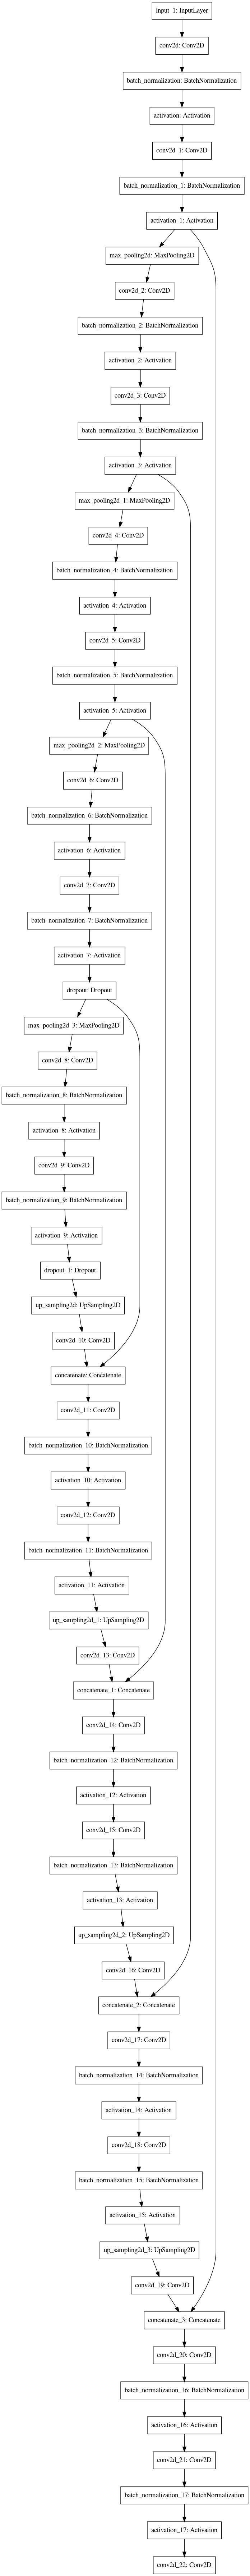

In [12]:
from tensorflow.keras.utils import plot_model
import pydot

plot_model(model)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## 2. 訓練

前のノートブックで用意したデータを使います。まず画像の前処理関数を作っておき

In [14]:
def preprocessing_function(x):
    return x / 255.

これをデータジェネレータに渡して前処理も組み込みます：

In [15]:
!ls /home/input/100knocks/lung_cancer/Segmentation01_RGB/train/label

img


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 乱数のシード
rand_seed = 42 

image_datagen = ImageDataGenerator(width_shift_range=0.1,
                 height_shift_range=0.1,
                 rotation_range = 0.2,
                 shear_range = 0.05,
                 zoom_range = 0.05,
                 preprocessing_function = preprocessing_function
                 )
mask_datagen = ImageDataGenerator(width_shift_range=0.1,
                 height_shift_range=0.1,
                 rotation_range = 0.2,
                 shear_range = 0.05,
                 zoom_range = 0.05,
                 preprocessing_function = preprocessing_function
                 )

image_generator =image_datagen.flow_from_directory('/home/input/100knocks/lung_cancer/Segmentation01_RGB/train/org',
                                                   class_mode=None, # 分類じゃないので、カテゴリに関するyを使わない
                                                   seed=rand_seed, 
                                                   target_size=(SIZE, SIZE), 
                                                   color_mode='grayscale') # 白黒なので1-channelにしておく

mask_generator = mask_datagen.flow_from_directory('/home/input/100knocks/lung_cancer/Segmentation01_RGB/train/label',
                                                  class_mode=None, 
                                                  seed=rand_seed, # 上と同じ乱数シードにしておくのがミソ。これで常にX線写真に対応するマスク画像を渡してくれる
                                                  target_size=(SIZE, SIZE), 
                                                  color_mode='grayscale')

train_generator = zip(image_generator, mask_generator) # zipで二つのイテレータをまとめる

Found 50 images belonging to 1 classes.
Found 50 images belonging to 1 classes.


ミニバッチサイズ5（steps_per_epoch=50//5）で学習させてみる

In [17]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')

history = model.fit(train_generator, 
          steps_per_epoch=50//5, 
          epochs=64)

Train for 10 steps
Epoch 1/64
10/10 [==============================] - 15s 1s/step - loss: 0.6054
Epoch 2/64
10/10 [==============================] - 2s 248ms/step - loss: 0.2553
Epoch 3/64
10/10 [==============================] - 2s 249ms/step - loss: 0.1655
Epoch 4/64
10/10 [==============================] - 3s 250ms/step - loss: 0.1333
Epoch 5/64
10/10 [==============================] - 3s 251ms/step - loss: 0.1165
Epoch 6/64
10/10 [==============================] - 2s 248ms/step - loss: 0.1069
Epoch 7/64
10/10 [==============================] - 2s 247ms/step - loss: 0.1023
Epoch 8/64
10/10 [==============================] - 2s 245ms/step - loss: 0.0964
Epoch 9/64
10/10 [==============================] - 2s 246ms/step - loss: 0.0930
Epoch 10/64
10/10 [==============================] - 3s 275ms/step - loss: 0.0894
Epoch 11/64
10/10 [==============================] - 3s 325ms/step - loss: 0.0868
Epoch 12/64
10/10 [==============================] - 3s 331ms/step - loss: 0.0846
Epoch 13

## 3. 学習結果を見てみる

データジェネレータから適当に訓練画像を取ってきて、それに関してセグメンテーションがうまくいっているかを見て見ましょう。まずは訓練ミニバッチを一つとってきます

In [18]:
xs, ys = next(train_generator)

In [19]:
print(xs.shape)
print(ys.shape)

(18, 128, 128, 1)
(18, 128, 128, 1)


それぞれxとyのペアを見てみると

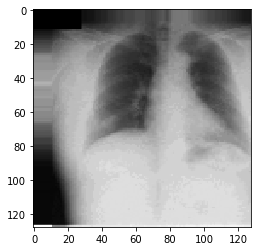

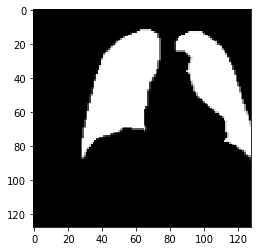

In [20]:
plt.imshow(xs[0,:,:,0], cmap='gray')
plt.show()

plt.imshow(ys[0,:,:,0], cmap='gray')
plt.show()

ではこれら訓練ミニバッチのうち16枚で、予測画像（左）と正解画像（右）を比較して見ましょう：

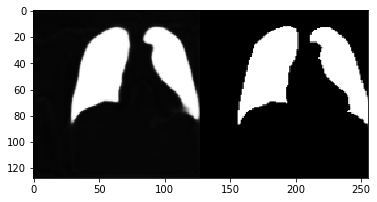

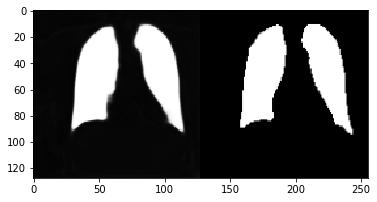

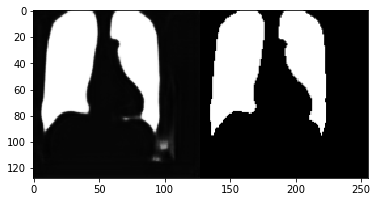

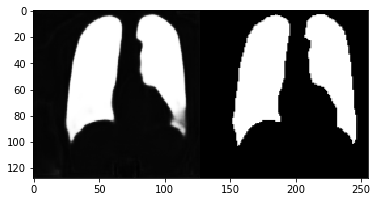

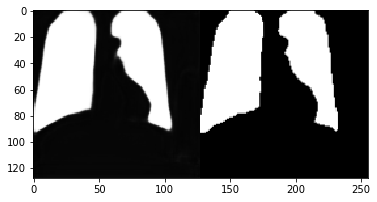

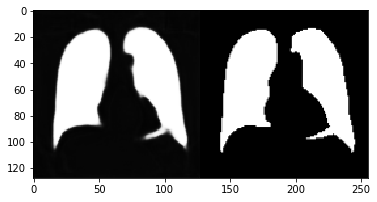

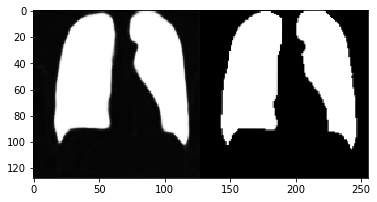

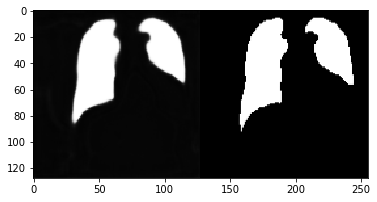

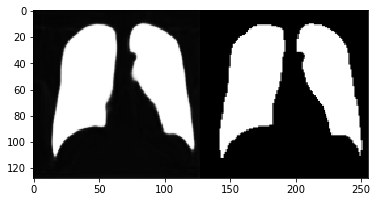

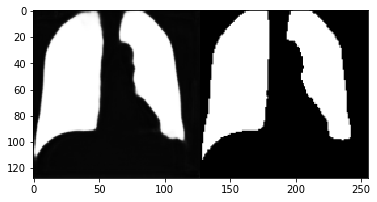

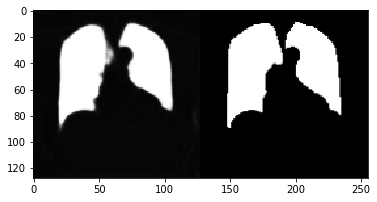

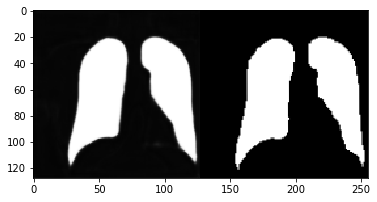

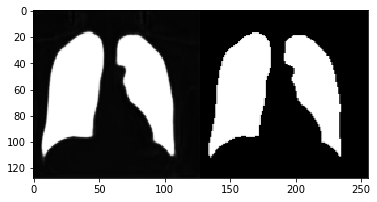

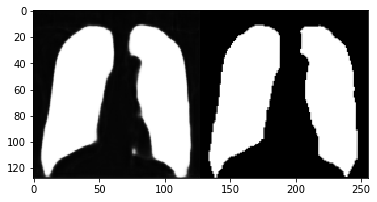

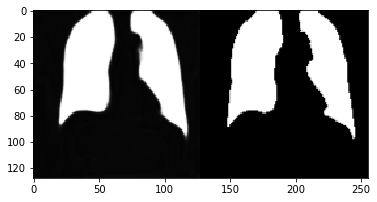

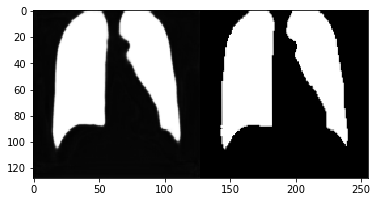

In [21]:
preds = model.predict(xs)

for i in range(16):
    img = np.concatenate([preds[i,:,:,0], ys[i,:,:,0]], axis=1)
    plt.imshow(img, cmap='gray')
    plt.show()

結構綺麗にいっています。

<b>ここでは検証データは用意してありませんので、検証（テスト）データでうまくいっているかも最後に確認しましょう。</b>